<a href="https://colab.research.google.com/github/Pseud0n1nja/Investment-Theses-Research-and-Analysis/blob/main/Tutorial_3_Finetuning_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this tutorial, we learn how to fine-tune the models for your specific use cases.**

This tutorial is the third of a series of tutorials. The first toutial [is here](https://medium.com/@schimanski.tobi/analyzing-esg-with-ai-and-nlp-tutorial-1-report-analysis-towards-esg-risks-and-opportunities-8daa2695f6c5). This tutorial is certainly more complex than the last ones. View this as a starting point and try to explore the concepts mentioned here step by step. The beauty of this code is that you can use it without entirely needing to understand every step. Understanding this can help you develop your own models and extend the datasets I have developed here. This is very important because you might find for instance that the models have flaws with spoken communication because they were only trained in written communication.

**IMPORTANT**: We simplify the data enhancement and evaluation process in this tutorial for the sake of demonstration. You need more data and a good evaluation framework to validate these things in the real world.

# Large Scale ESG Report Analysis

**By Tobias Schimanski and based on my paper: "Bridiging the Gap in ESG Measurement: Using NLP to Quantify Environmental, Social, and Governance Communication"**

This notebook serves as a basis for applying AI Natural Language Processing tools to corporate sustainability reports. It is particularily tailored for newcomers to the field with limited or no prior experience. In this tutorial, you can only press play and will be fine.

If you are already advanced, you might just [want to read the paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4622514) and or go directly to the [models on HuggingFace](https://huggingface.co/ESGBERT).

## SET RUNTIME TO GPU

In order to use the models on large-scale, we want to use GPUs (processing units that are super fast). For this, we gut on "Runtime" underneath the tutorial name, choose "Change runtime type" and then select any "GPU", probably "T4 GPU" if you are not a premium user.

## Import libraries

We start by installing and importing some standard libraries as well as the "transformers" one. This will help us to use the tools.

In [ ]:
!pip install transformers
!pip install accelerate
!pip install datasets

In [ ]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import datasets
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline # for using the models
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback # functions for the training

## Problem Statement

As you might know, the models are already uploaded to HuggingFace in their fine-tuned version. But you might also find some limitations when using them. For instance, spoken communication with the SocialBERT models sometimes leads to irretations. See the following example.

In [ ]:
# Load the model as usual
tokenizer_name = "ESGBERT/SocialBERT-social"
model_name = "ESGBERT/SocialBERT-social"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, max_len=512)
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
# Example
pipe("Have a great day.")

[{'label': 'social', 'score': 0.5510378479957581}]

When using the model and looking at the classifications, you might encounter something like this. The training process seems to steer the model to think that short, "nice"/ "social interaction" sentences are also part of the "social" label. This is likely because we trained the model to learn that "nice"/"social interaction" sentences in annual reports are "social". And now, this is a false generalization to spoken communication.

In this tutorial, I present how to fine-tune a model but more importantly, how to enhance the data with such misclassifications to overcome these problems for your use case.

# Dataset loading and adjustment

In this step, we first load the data. We want to split the data into a training dataset which will be used to finetune the model, an evaluation dataset to see evaluate the model *during* training and a test dataset to evaluate the model *after* training.

In [ ]:
# use the dataset from the paper that is available on HuggingFace
dataset_name = "ESGBERT/social_2k"
hf_dataset = datasets.load_dataset(dataset_name)
data = hf_dataset["train"].to_pandas()[["text", "soc"]]

# traintest split using the non-preprocessed data (df)
# use stratify to keep the label distribution of the original dataset
# use random_state to always have the same outcome of the split
train, test = train_test_split(data, test_size=.2, stratify=data["soc"], random_state=42)
train, val = train_test_split(train, test_size=.2, stratify=train["soc"], random_state=42)

print('Train samples: {}'.format(train.shape[0]))
print('Val samples: {}'.format(val.shape[0]))
print('Test samples: {}'.format(test.shape[0]))

Train samples: 1280
Val samples: 320
Test samples: 400


In [ ]:
# look at the train data
train.head()

,text,soc
1929,The majority of suppliers already had access t...,0
1099,Our approach to ESG and sustainability is fund...,1
6,Training The training delivered is designed to...,1
795,The Directors believe that the Company's succe...,1
1889,Our goal is for every employee to feel a stron...,1


One important step for us is to add some examples of these false behaviors identified earlier to the training data. A good practice is to gather a large amount of samples and add them to the data. For the sake of demonstration, we will only work with a few samples that address this specific problem of "nice"/ "social interaction".

In [ ]:
# Social interaction examples
social_int = ["You're welcome!", "I'm happy to help you", "Good morning everyone.", "It is great to see you all.", "Help is always appreciated", "I wish you all the best."]

# Add these samples to the training data
add_soc = pd.DataFrame({"text": social_int})
# assign 0 ("not social") to all texts
add_soc["soc"] = 0
# add to train
train = pd.concat([train, add_soc])

## Fine-tuning

Now, we create a configuration for our hyperparameters for fine-tuning. Hyperparameters help us to configure "how" we want to train the model. To understand this fully, you might want to have another deep dive and google all the terms. I will give a short explanation next to the most important parameters used here. I would recommend using the same hyperparameters that I use in the [paper about ESG BERTs](https://www.sciencedirect.com/science/article/pii/S1544612324000096?via%3Dihub) in your final applications.

In this tutorial, we want to finetune the "SocialBERT-base" model that was also used to train "SocialBERT-social". This time, we train it with the additional few sentences, we just added.

In [ ]:
# costum Config
class Config:
  model = 'ESGBERT/SocialBERT-base' # the model we want to fine-tune
  tokenizer = 'ESGBERT/SocialBERT-base' # the used tokenizer that transforms text to machine-readable bits
  # define classification task
  task = "soc" # take a look at the dataset (below): the column with the labels is called "env"
  steps = 20 # after how many steps of training do I want the model to be evaluated
  epochs = 5 # how often will the dataset run through the model
  batch_size = 16 # how many single datapoint (i.e. sentences)
  learning_rate = 5e-5 # how "fast" should the model learn the data

  # not necessary to understand but google these concepts if you feel like it
  gradient_accumulation = 2
  warmup_ratio = 0.1
  weight_decay = 0.1
  patience = 3
  device = 'cuda'

Ok, now from here on it gets very complicated if you do not yet have machine learning experience. I would recommend you to see the following function as a given for now. It basically takes the configuration details and the data and just executes the model training. In my eyes, you don't need to change this function anyway if you do your own fine-tuning.

In [ ]:
def finetuneModel(Config, train, val):
  # Tokenizer
  # preparing the inputs for a model
  tokenizer = AutoTokenizer.from_pretrained(Config.tokenizer)
  def tokenize(batch):
      tokens = tokenizer(batch['text'], truncation=True, max_length=512)
      tokens['labels'] = batch['labels']
      return tokens

  # Data Collator
  # helps to form a batch of dataset objects
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  # Fill in training arguments from Config
  training_args = TrainingArguments(
      output_dir="./",
      overwrite_output_dir = False,
      evaluation_strategy="steps",
      logging_strategy="steps",
      logging_steps=Config.steps,
      eval_steps=Config.steps,
      num_train_epochs=Config.epochs,
      per_device_train_batch_size=Config.batch_size,
      per_device_eval_batch_size=Config.batch_size,
      learning_rate=Config.learning_rate,
      weight_decay=Config.weight_decay,
      gradient_accumulation_steps=Config.gradient_accumulation,
      warmup_ratio=Config.warmup_ratio,
      metric_for_best_model='eval_f1', # eval_f1
      load_best_model_at_end=True,
      )

  # Evaluation metrics
  # we want accuracy, f1, precision and recall as our metrics for evaluation
  def compute_metrics(pred):
      labels = pred.label_ids
      preds = pred.predictions.argmax(-1)
      precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
      acc = accuracy_score(labels, preds)
      return {
          'accuracy': acc,
          'f1': f1,
          'precision': precision,
          'recall': recall
      }

  # model inititialisation
  # we use the base model of Environmental-BERT
  model = AutoModelForSequenceClassification.from_pretrained(Config.model, num_labels=2)

  # HuggingFace Dataset structure
  # create a datastructure that the HuggingFace model can read
  train_dict = {'text': train["text"], 'labels': train[Config.task]}
  val_dict = {'text': val["text"], 'labels': val[Config.task]}
  train_dataset = datasets.Dataset.from_dict(train_dict)
  val_dataset = datasets.Dataset.from_dict(val_dict)
  # tokenize
  train_dataset = train_dataset.map(tokenize, num_proc=1, batched=True, remove_columns=["text"])
  val_dataset = val_dataset.map(tokenize, num_proc=1, batched=True, remove_columns=["text"])

  # Trainer
  # object that combines all prior steps
  trainer = Trainer(
      model,
      training_args,
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      data_collator=data_collator,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
      callbacks=[EarlyStoppingCallback(early_stopping_patience=Config.patience)]
  )

  # start the model training
  trainer.train()

  # return the final model
  return model, tokenizer

Start the training by evoking the function.

In [ ]:
model, tokenizer = finetuneModel(Config, train, val)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ESGBERT/SocialBERT-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1286 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
20,0.647700,0.527200,0.600000,0.382202,0.799373,0.503876
40,0.390500,0.258104,0.881250,0.879728,0.878592,0.892975
60,0.192800,0.330279,0.875000,0.873892,0.875620,0.890255
80,0.205100,0.226013,0.906250,0.904909,0.902783,0.917691
100,0.105900,0.187273,0.940625,0.938818,0.935902,0.942713
120,0.090700,0.218818,0.928125,0.925596,0.924162,0.927209
140,0.044400,0.345818,0.896875,0.895626,0.894700,0.909838
160,0.075500,0.254281,0.925000,0.923417,0.919606,0.932140
180,0.031200,0.284527,0.915625,0.914073,0.910669,0.924287
200,0.011200,0.287635,0.912500,0.910966,0.907767,0.921669


# Evaluate fine-tuned model

Now, let's see if the adjustment worked by loading the trained model into a classification pipeline.

In [ ]:
# Load the model
new_social_pipe = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=0)

In [ ]:
new_social_pipe("Have a great day.")

[{'label': 'LABEL_0', 'score': 0.9949280023574829}]

By only adding a few examples to the training data, we adjusted the model behavior to detect that this example of "nice social interaction" is not really within the scope of the real "social" label. Of course, this only represents an example.

For the sake of completeness, I also add code on how to evaluate the model generally on the testing data. It is always important to still check the performance on the original test set when adjusting the training data.

In [ ]:
# Get text and labels as array
text = test["text"].to_numpy().astype(str)
labels = test[Config.task].to_numpy()

# Helper for the transformation of the output
# this model currently outputs LABEL_1 for "social" and LABEL_0 for "none"
# LABEL_1 for social
def label_to_num(inp):
    if inp == 'LABEL_0':
        return 0
    elif inp == 'LABEL_1':
        return 1

# Helper for the use of the transformer
def useTransformer(arr, classifier):
  arr_2 = classifier([x for x in arr])
  res = [label_to_num(x['label']) for x in arr_2]
  return res

# Helper to show output
def evaluate(labels, pred, name):
  print("Evaluation of " + name)
  print(classification_report(labels, pred))
  confMat = confusion_matrix(labels, pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=confMat, display_labels=["no", "yes"])
  disp.plot()
  plt.show()

# Predict
pred = useTransformer(text, new_social_pipe)

soc
Evaluation of ESGBERT/SocialBERT-base
              precision    recall  f1-score   support

           0       0.99      0.92      0.95       239
           1       0.89      0.98      0.93       161

    accuracy                           0.94       400
   macro avg       0.94      0.95      0.94       400
weighted avg       0.95      0.94      0.95       400



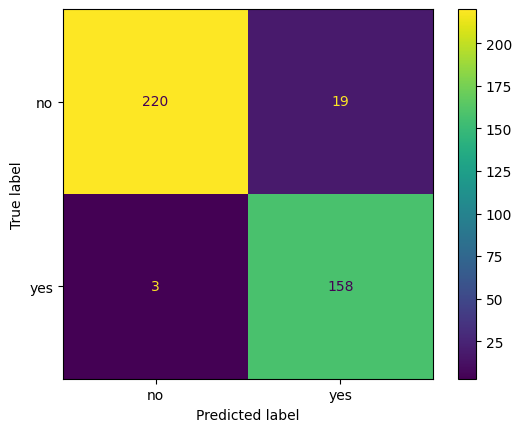

In [ ]:
# Output
print(Config.task)
evaluate(labels, pred, Config.model)

The results on the original test dataset are still extremely good.

This is it for today. I think it's quite a lot to digest. I wanted to cover a variety of aspects in this one tutorial. So take your time to go through the individual steps. Also, feel free to read the [paper on the ESG BERTs](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4622514) or follow [me on LinkedIn](https://www.linkedin.com/in/tobias-schimanski-964077182/) to not miss out on new developments.